# Similar to the other notebook but for seasonal channeling plots + following Thomas' suggestions

Adventdalen - Plataberget

Longyeardalen - Plataberget (channling compared to synoptic flow)

Adventdalen - Longyeardalen (with color from Platåberget wind speed)

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.interpolate import griddata

import sys
sys.path.append("..")

from channeling_lib import AWS_file_loader, load_path
path = load_path()

In [2]:
end_date_now = np.datetime64('2025-01-01')
stations = {'SN99870':{'name':'Adventdalen',
                       'has_wind_data': True, 
                       'wind_direction_data_name':'wind_from_direction',
                       'wind_speed_data_name':'wind_speed',
                       'id':'SN99870',
                       'elevation': 15,
                       'latitude':78.2022,
                       'longitude':15.831,
                        'start_date': np.datetime64('2016-11-21'),
                       'end_date': end_date_now,
                       'valley_orientation':304%180},
            'SN99864':{'name':'Nybyen',
                       'has_wind_data': True, 
                       'wind_direction_data_name':'mean(wind_from_direction PT1M)',
                       'wind_speed_data_name':'mean(wind_speed PT1M)',
                       'id':'SN99864',
                       'elevation': 114,
                       'latitude':78.201609,
                       'longitude':15.59266,
                        'start_date': np.datetime64('2023-11-03'),
                       'end_date': end_date_now,
                       'valley_orientation':30}, # degrees from north
             'SN99858':{'name':'Vannledningsdalen',
                        'has_wind_data': True, 
                       'wind_direction_data_name':'mean(wind_from_direction PT1M)',
                       'wind_speed_data_name':'mean(wind_speed PT1M)',
                       'id':'SN99858',
                       'elevation': 70,
                       'latitude':78.2128,
                       'longitude':15.633,
                        'start_date': np.datetime64('2023-11-03'),
                       'end_date': end_date_now,
                       'valley_orientation':31},
            'SN99840':{'name':'Svalbard Lufthavn',
                       'has_wind_data': True, 
                       'wind_direction_data_name':'wind_from_direction',
                       'wind_speed_data_name':'wind_speed',
                       'id':'SN99840',
                       'elevation': 28,
                       'latitude':78.2453,
                       'longitude':15.5015,
                        #'start_date': np.datetime64('1964-10-16'),
                        'start_date': np.datetime64('1994-12-31'),
                       'end_date': end_date_now,
                       'valley_orientation':305%180}, 
            'SN99843':{'name':'Platåberget III',
                       'has_wind_data': True,
                       'wind_direction_data_name':'wind_from_direction',
                       'wind_speed_data_name':'wind_speed',
                       'id':'SN99843',
                       'elevation': 450,
                       'latitude':78.2278,
                       'longitude':15.378,
                        'start_date': np.datetime64('2018-02-01'),
                       'end_date': end_date_now,
                       'valley_orientation':None}, 
            'SN99857':{'name':'Longyeardalen - Central',
                       'has_wind_data': True,
                       'wind_direction_data_name':'wind_from_direction',
                       'wind_speed_data_name':'wind_speed',
                       'id':'SN99857',
                       'elevation': 52,
                       'latitude':78.2127,
                       'longitude':15.6107,
                        'start_date': np.datetime64('2023-09-16'),
                       'end_date': end_date_now,
                       'valley_orientation':32} }

In [3]:
for id_station in tqdm(list(stations.keys())):
    stations[id_station]['wind_speed_data'] = pd.read_csv(path+'SeklimaData/Output/'+id_station+'_'+
                                                          stations[id_station]['wind_speed_data_name']+'.csv',
                                                         parse_dates=['referenceTime'])
    stations[id_station]['wind_direction_data'] = pd.read_csv(path+'SeklimaData/Output/'+id_station+'_'+
                                                          stations[id_station]['wind_direction_data_name']+'.csv',
                                                         parse_dates=['referenceTime'])


100%|███████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  4.12s/it]


# Adventdalen - Plataberget

In [4]:
ws_plataberget = stations['SN99843']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_plataberget'})
ws_adventdalen = stations['SN99870']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_adventdalen'})
wd_plataberget = stations['SN99843']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_plataberget'})
wd_adventdalen = stations['SN99870']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_adventdalen'})

print(ws_plataberget.timeResolution.value_counts(), ws_adventdalen.timeResolution.value_counts())
ws_adventdalen = ws_adventdalen.resample('h').mean(numeric_only=True).dropna(subset=['ws_adventdalen'])
wd_adventdalen = wd_adventdalen.resample('h').mean(numeric_only=True).dropna(subset=['wd_adventdalen'])

adventdalen_plataberget_df = pd.DataFrame(ws_adventdalen.copy()['ws_adventdalen'])

adventdalen_plataberget_df = adventdalen_plataberget_df.merge(wd_adventdalen.wd_adventdalen, left_index=True, right_index=True, how="left")
adventdalen_plataberget_df = adventdalen_plataberget_df.merge(ws_plataberget.ws_plataberget, left_index=True, right_index=True, how="left")
adventdalen_plataberget_df = adventdalen_plataberget_df.merge(wd_plataberget.wd_plataberget, left_index=True, right_index=True, how="left")

adventdalen_plataberget_df.dropna(axis=0, inplace=True)

timeResolution
PT1H    98605
Name: count, dtype: int64 timeResolution
PT1H    141234
Name: count, dtype: int64


<Axes: xlabel='referenceTime'>

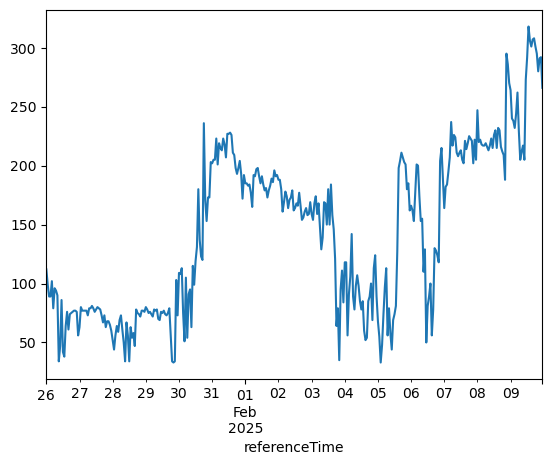

In [5]:
plataberget_AGFperiod_raw = pd.read_csv(load_path()+'SeklimaData/Plataberget_wind_20250126-20250210.csv', parse_dates=['referenceTime'])#, index_col='referenceTime')
plataberget_AGFperiod_raw['referenceTime'] = plataberget_AGFperiod_raw['referenceTime'].dt.tz_localize(None)
plataberget_AGFperiod_raw.set_index('referenceTime', inplace=True)

plataberget_AGFperiod = pd.DataFrame(plataberget_AGFperiod_raw.loc[plataberget_AGFperiod_raw.elementId=='wind_from_direction']['value']
                                    ).rename(columns={'value':'plataberget_wind_from_direction'})
plataberget_AGFperiod['plataberget_wind_speed'] = plataberget_AGFperiod_raw.loc[plataberget_AGFperiod_raw.elementId=='wind_speed']['value']

plataberget_AGFperiod.plataberget_wind_from_direction.plot()

In [6]:
fnames = ! ls {load_path()}CalibratedData/AWS/*.csv

channeling_our_obs_plataberget_adventdalen = pd.DataFrame({'wd_AWS':[], 'wd_plataberget':[]})

def mean_wind_direction(wind_directions):
    wind_directions = np.radians(wind_directions)  # Convert to radians
    u = np.cos(wind_directions)
    v = np.sin(wind_directions)
    
    mean_u = np.mean(u)
    mean_v = np.mean(v)
    
    mean_angle = np.arctan2(mean_v, mean_u)  # Compute mean angle
    mean_angle = np.degrees(mean_angle)  # Convert back to degrees
    return mean_angle % 360  # Ensure it is within 0-360°

for fn in fnames:
    if not fn.split('/')[-1].startswith('bettedavis'):
        df_temp = pd.read_csv(fn, parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')
        df_temp = df_temp.resample('h').apply(mean_wind_direction)
        df_temp = df_temp.merge(plataberget_AGFperiod.plataberget_wind_from_direction, left_index=True, right_index=True, how="left")
        channeling_our_obs_plataberget_adventdalen = pd.concat([channeling_our_obs_plataberget_adventdalen, pd.DataFrame({'wd_AWS':df_temp.wind_direction,
                                                                          'wd_plataberget':df_temp.plataberget_wind_from_direction})], ignore_index=True)
        print(df_temp.index[0], df_temp.index[-1])

2025-01-26 11:00:00 2025-02-03 11:00:00
2025-01-27 14:00:00 2025-02-03 10:00:00
2025-01-27 10:00:00 2025-02-03 09:00:00
2025-01-26 14:00:00 2025-02-03 12:00:00


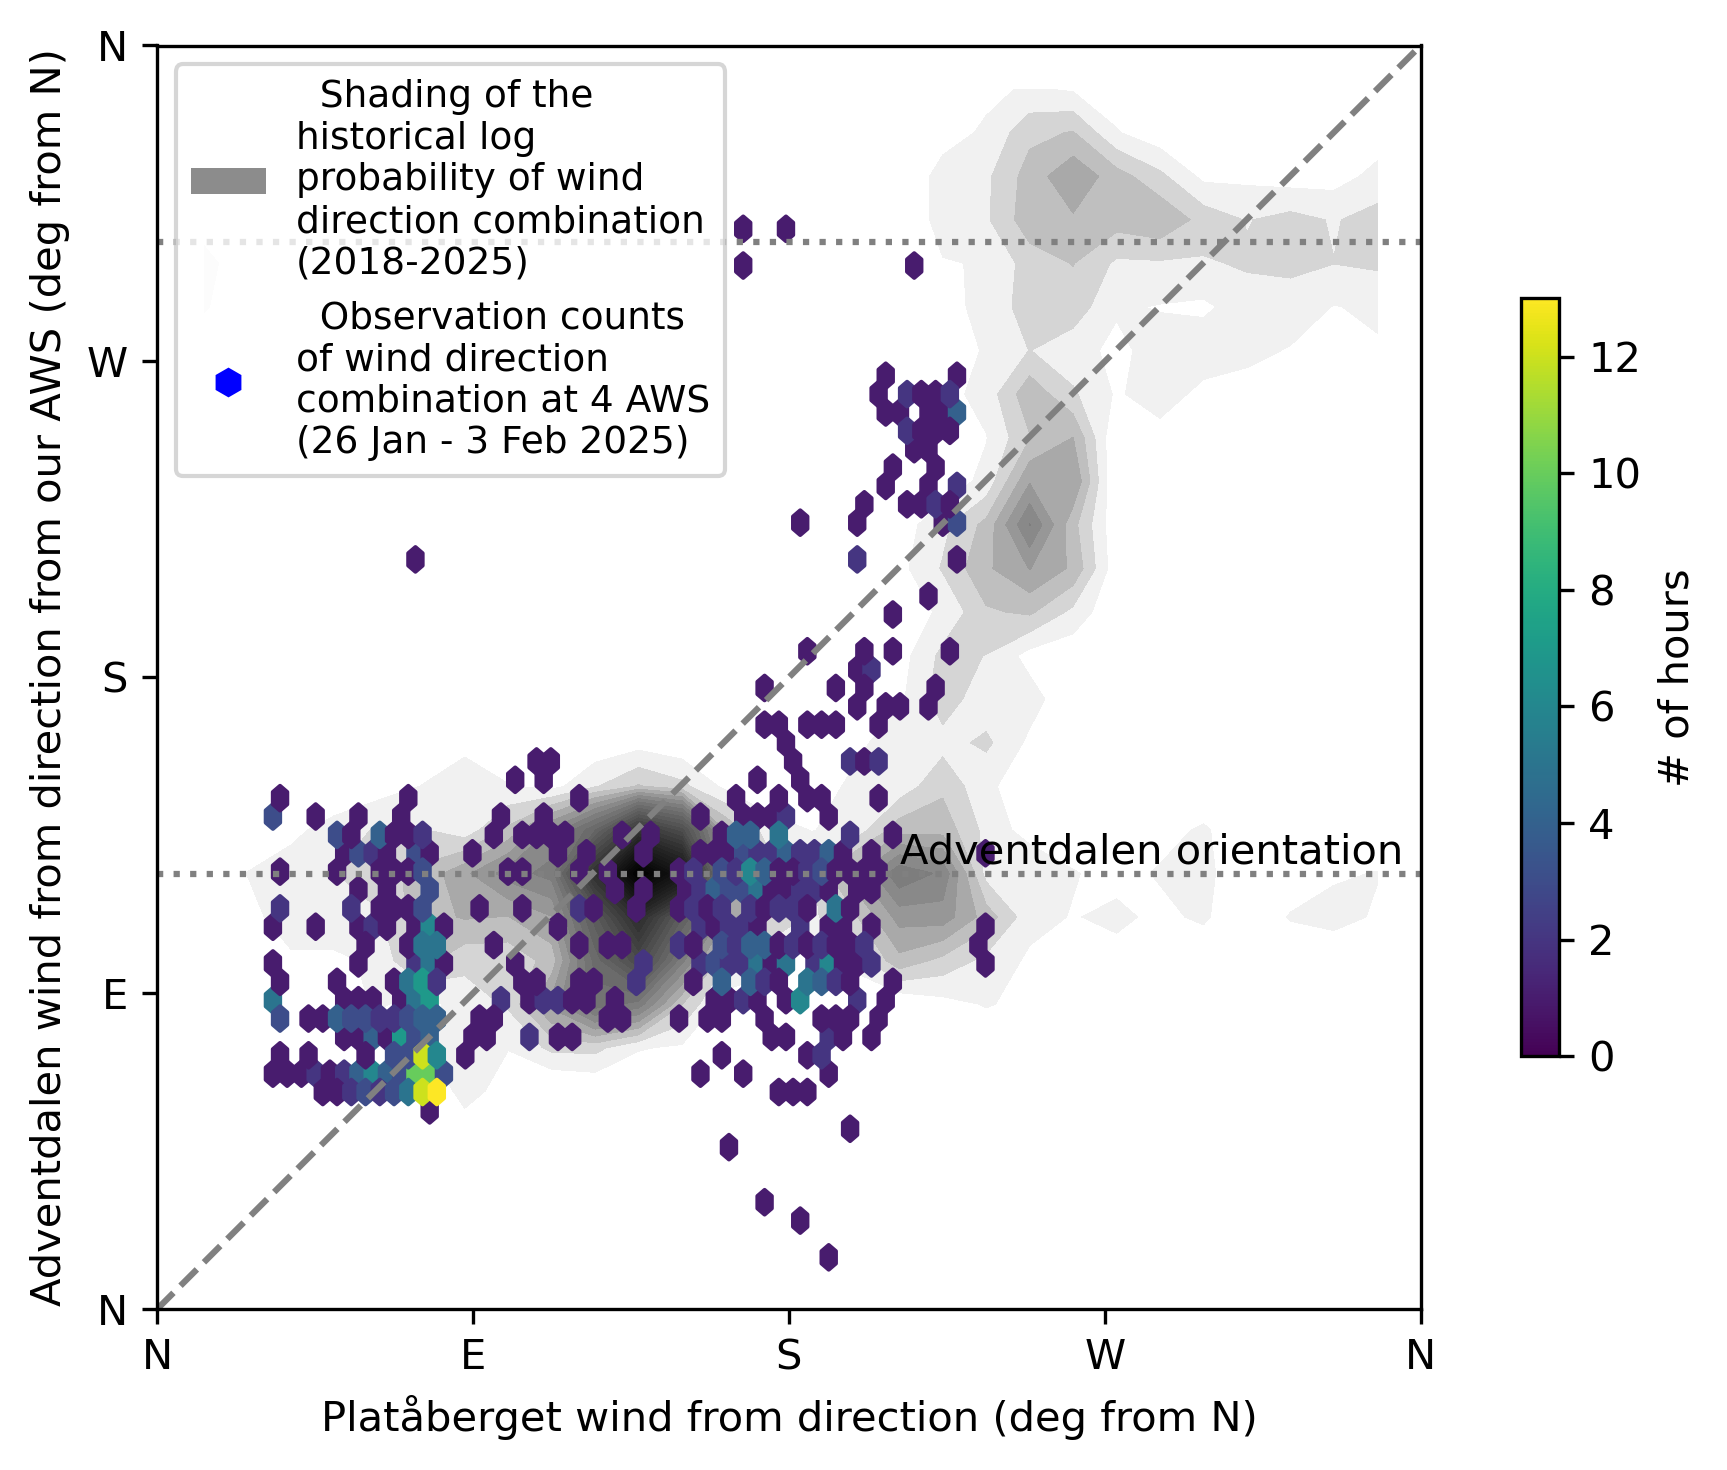

In [7]:
###### For wind speeds > than some value in m/s
#wind_speeds = [2,5,10] # length L : L+1 plots

fig,ax = plt.subplots(figsize=(7,5), dpi=300)

vmax=13 # for scaling purposes
vmin=0
min_ws = 2

condi = adventdalen_plataberget_df.ws_plataberget >= min_ws
x = adventdalen_plataberget_df.loc[condi].wd_plataberget
y = adventdalen_plataberget_df.loc[condi].wd_adventdalen

counts, xedges, yedges = np.histogram2d(x, y, bins=30)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xcenters, ycenters)

# Step 3: Interpolate counts onto a finer grid
xi = np.linspace(x.min(), x.max(), 30)  # Fine grid for contours
yi = np.linspace(y.min(), y.max(), 30)
XI, YI = np.meshgrid(xi, yi)
ZI = griddata((X.ravel(), Y.ravel()), counts.T.ravel(), (XI, YI), method='cubic')

ax.contourf(XI, YI, ZI, levels=30, cmap="Greys", norm='log')
#ax.hexbin(x ,y , mincnt=1, vmax=vmax, vmin=vmin, cmap='Greys')
#ax.set_title(r'$w_s < %.1f\ m\ s^{-1}$'%wind_speeds[0])

ax.set_aspect('equal')
ax.set_xlim(0,360)
ax.set_ylim(0,360)
ax.axline([0,0], slope=1, c='grey', ls='--')
ax.set_xticks([0,90,180,270,360], labels=['N','E','S','W','N'])
ax.set_yticks([0,90,180,270,360], labels=['N','E','S','W','N'])
    #ax.grid()

ax.set_xlabel('Platåberget wind from direction (deg from N)')
ax.set_ylabel('Adventdalen wind from direction from our AWS (deg from N)')
#fig.colorbar(pcm, ax=axs, orientation='horizontal', location='top', pad=-.45, shrink=.5, label='counts')

ax.legend([Patch(facecolor='grey', alpha=.9),
           Line2D([0], [0], lw=0, marker='h', color='blue')],
                  ['  Shading of the\nhistorical log\nprobability of wind\ndirection combination\n(2018-2025)', 
                   '  Observation counts\nof wind direction\ncombination at 4 AWS\n(26 Jan - 3 Feb 2025)'], loc='upper left', fontsize=9)

pcm=ax.hexbin(channeling_our_obs_plataberget_adventdalen.wd_plataberget, channeling_our_obs_plataberget_adventdalen.wd_AWS,
              mincnt=1, vmax=vmax, vmin=vmin, gridsize=50)
fig.colorbar(pcm, shrink=.6, label='# of hours')
ax.axhline(stations['SN99870']['valley_orientation'], ls=':', c='grey')
ax.axhline(stations['SN99870']['valley_orientation']+180, ls=':', c='grey')
ax.text(355, stations['SN99870']['valley_orientation']+3, 'Adventdalen orientation', ha='right')
fig.tight_layout()

plt.savefig('../figs/channeling_adventdalen_our_storm_VS_history.png')

## Now historical summer/winter channeling plots

/tmp/ipykernel_227956/498633342.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels((np.arange(0,1001,200)/(2025.1-2016.9)).astype(int).astype(str))
/tmp/ipykernel_227956/498633342.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


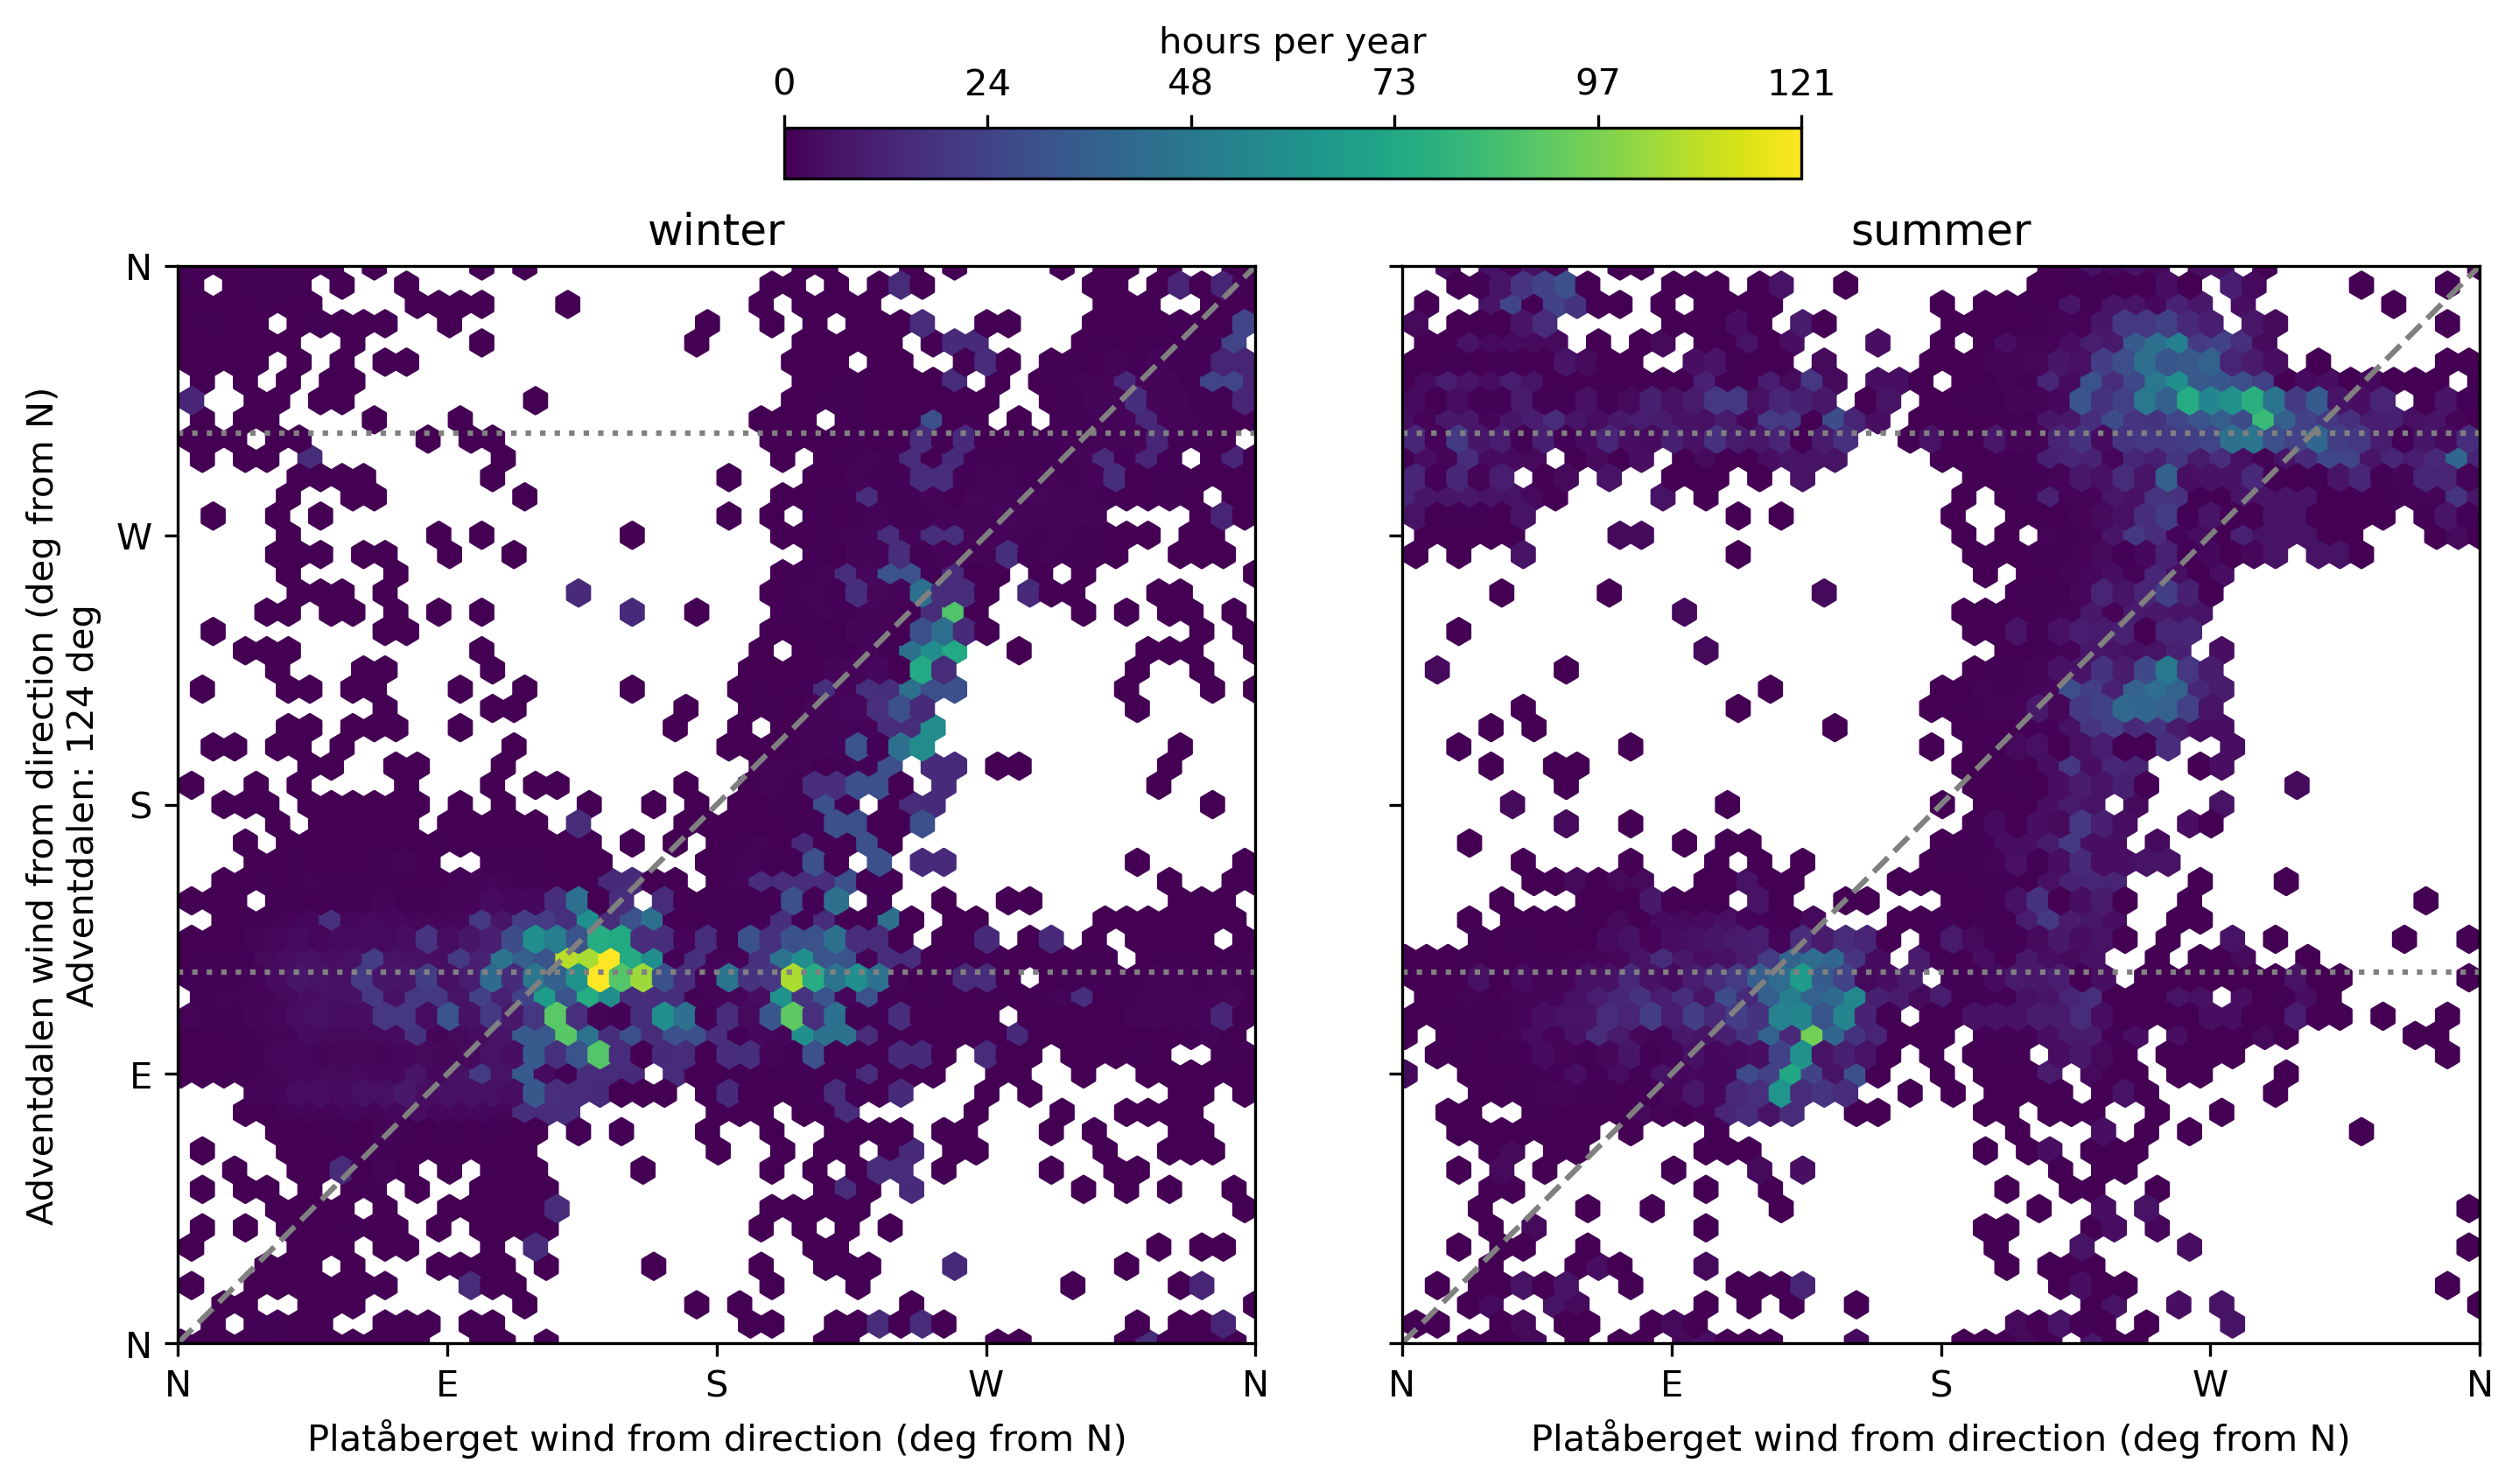

In [8]:
###### For wind speeds > than some value in m/s

fig,axs = plt.subplots(ncols=2, figsize=(10,6), sharex=True, sharey=True, dpi=300)
axs = axs.ravel()

vmax=1000 # for scaling purposes
vmin=0

ws_min = 2

condi_ws = adventdalen_plataberget_df.ws_plataberget>2

condi_m = adventdalen_plataberget_df.index.month.isin([1,2,12])
pcm=axs[0].hexbin(adventdalen_plataberget_df.loc[np.logical_and(condi_m, condi_ws)].wd_plataberget,
              adventdalen_plataberget_df.loc[np.logical_and(condi_m, condi_ws)].wd_adventdalen, mincnt=1, gridsize=50, vmax=vmax, vmin=vmin)

axs[0].set_title('winter')


condi_m = adventdalen_plataberget_df.index.month.isin([6,7,8])
axs[1].hexbin(adventdalen_plataberget_df.loc[np.logical_and(condi_m, condi_ws)].wd_plataberget,
              adventdalen_plataberget_df.loc[np.logical_and(condi_m, condi_ws)].wd_adventdalen, mincnt=1, gridsize=50, vmax=vmax, vmin=vmin)

axs[1].set_title('summer')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(0,360)
    ax.set_ylim(0,360)
    ax.axline([0,0], slope=1, c='grey', ls='--')
    ax.set_xticks([0,90,180,270,360], labels=['N','E','S','W','N'])
    ax.set_yticks([0,90,180,270,360], labels=['N','E','S','W','N'])
    ax.axhline(stations['SN99870']['valley_orientation'], ls=':', c='grey')
    ax.axhline(stations['SN99870']['valley_orientation']+180, ls=':', c='grey')
    #ax.grid()

for i in [0,1]: axs[i].set_xlabel('Platåberget wind from direction (deg from N)')
axs[0].set_ylabel('Adventdalen wind from direction (deg from N)\nAdventdalen: %i deg'
                 %(stations['SN99870']['valley_orientation']))
cbar=fig.colorbar(pcm, ax=axs, orientation='horizontal', location='top', pad=-.45, shrink=.5, label='hours per year')

cbar.set_ticklabels((np.arange(0,1001,200)/(2025.1-2016.9)).astype(int).astype(str))

fig.tight_layout()

plt.savefig('../figs/seasonal_channeling_adventdalen_VS_synoptic.png', bbox_inches='tight')


# Longyeardalen - Plataberget (channling compared to synoptic flow)

Using Longyearbyen central: SN99857

In [9]:
ws_plataberget = stations['SN99843']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_plataberget'})
ws_longyearbyen = stations['SN99858']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_longyearbyen'})
wd_plataberget = stations['SN99843']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_plataberget'})
wd_longyearbyen = stations['SN99858']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_longyearbyen'})

print(ws_plataberget.timeResolution.value_counts(), ws_longyearbyen.timeResolution.value_counts())
ws_longyearbyen = ws_longyearbyen.resample('h').mean(numeric_only=True).dropna(subset=['ws_longyearbyen'])
wd_longyearbyen = wd_longyearbyen.resample('h').mean(numeric_only=True).dropna(subset=['wd_longyearbyen'])

longyearbyen_plataberget_df = pd.DataFrame(ws_longyearbyen.copy()['ws_longyearbyen'])

longyearbyen_plataberget_df = longyearbyen_plataberget_df.merge(wd_longyearbyen.wd_longyearbyen, left_index=True, right_index=True, how="left")
longyearbyen_plataberget_df = longyearbyen_plataberget_df.merge(ws_plataberget.ws_plataberget, left_index=True, right_index=True, how="left")
longyearbyen_plataberget_df = longyearbyen_plataberget_df.merge(wd_plataberget.wd_plataberget, left_index=True, right_index=True, how="left")

longyearbyen_plataberget_df.dropna(axis=0, inplace=True)

timeResolution
PT1H    98605
Name: count, dtype: int64 timeResolution
PT1M    631757
Name: count, dtype: int64


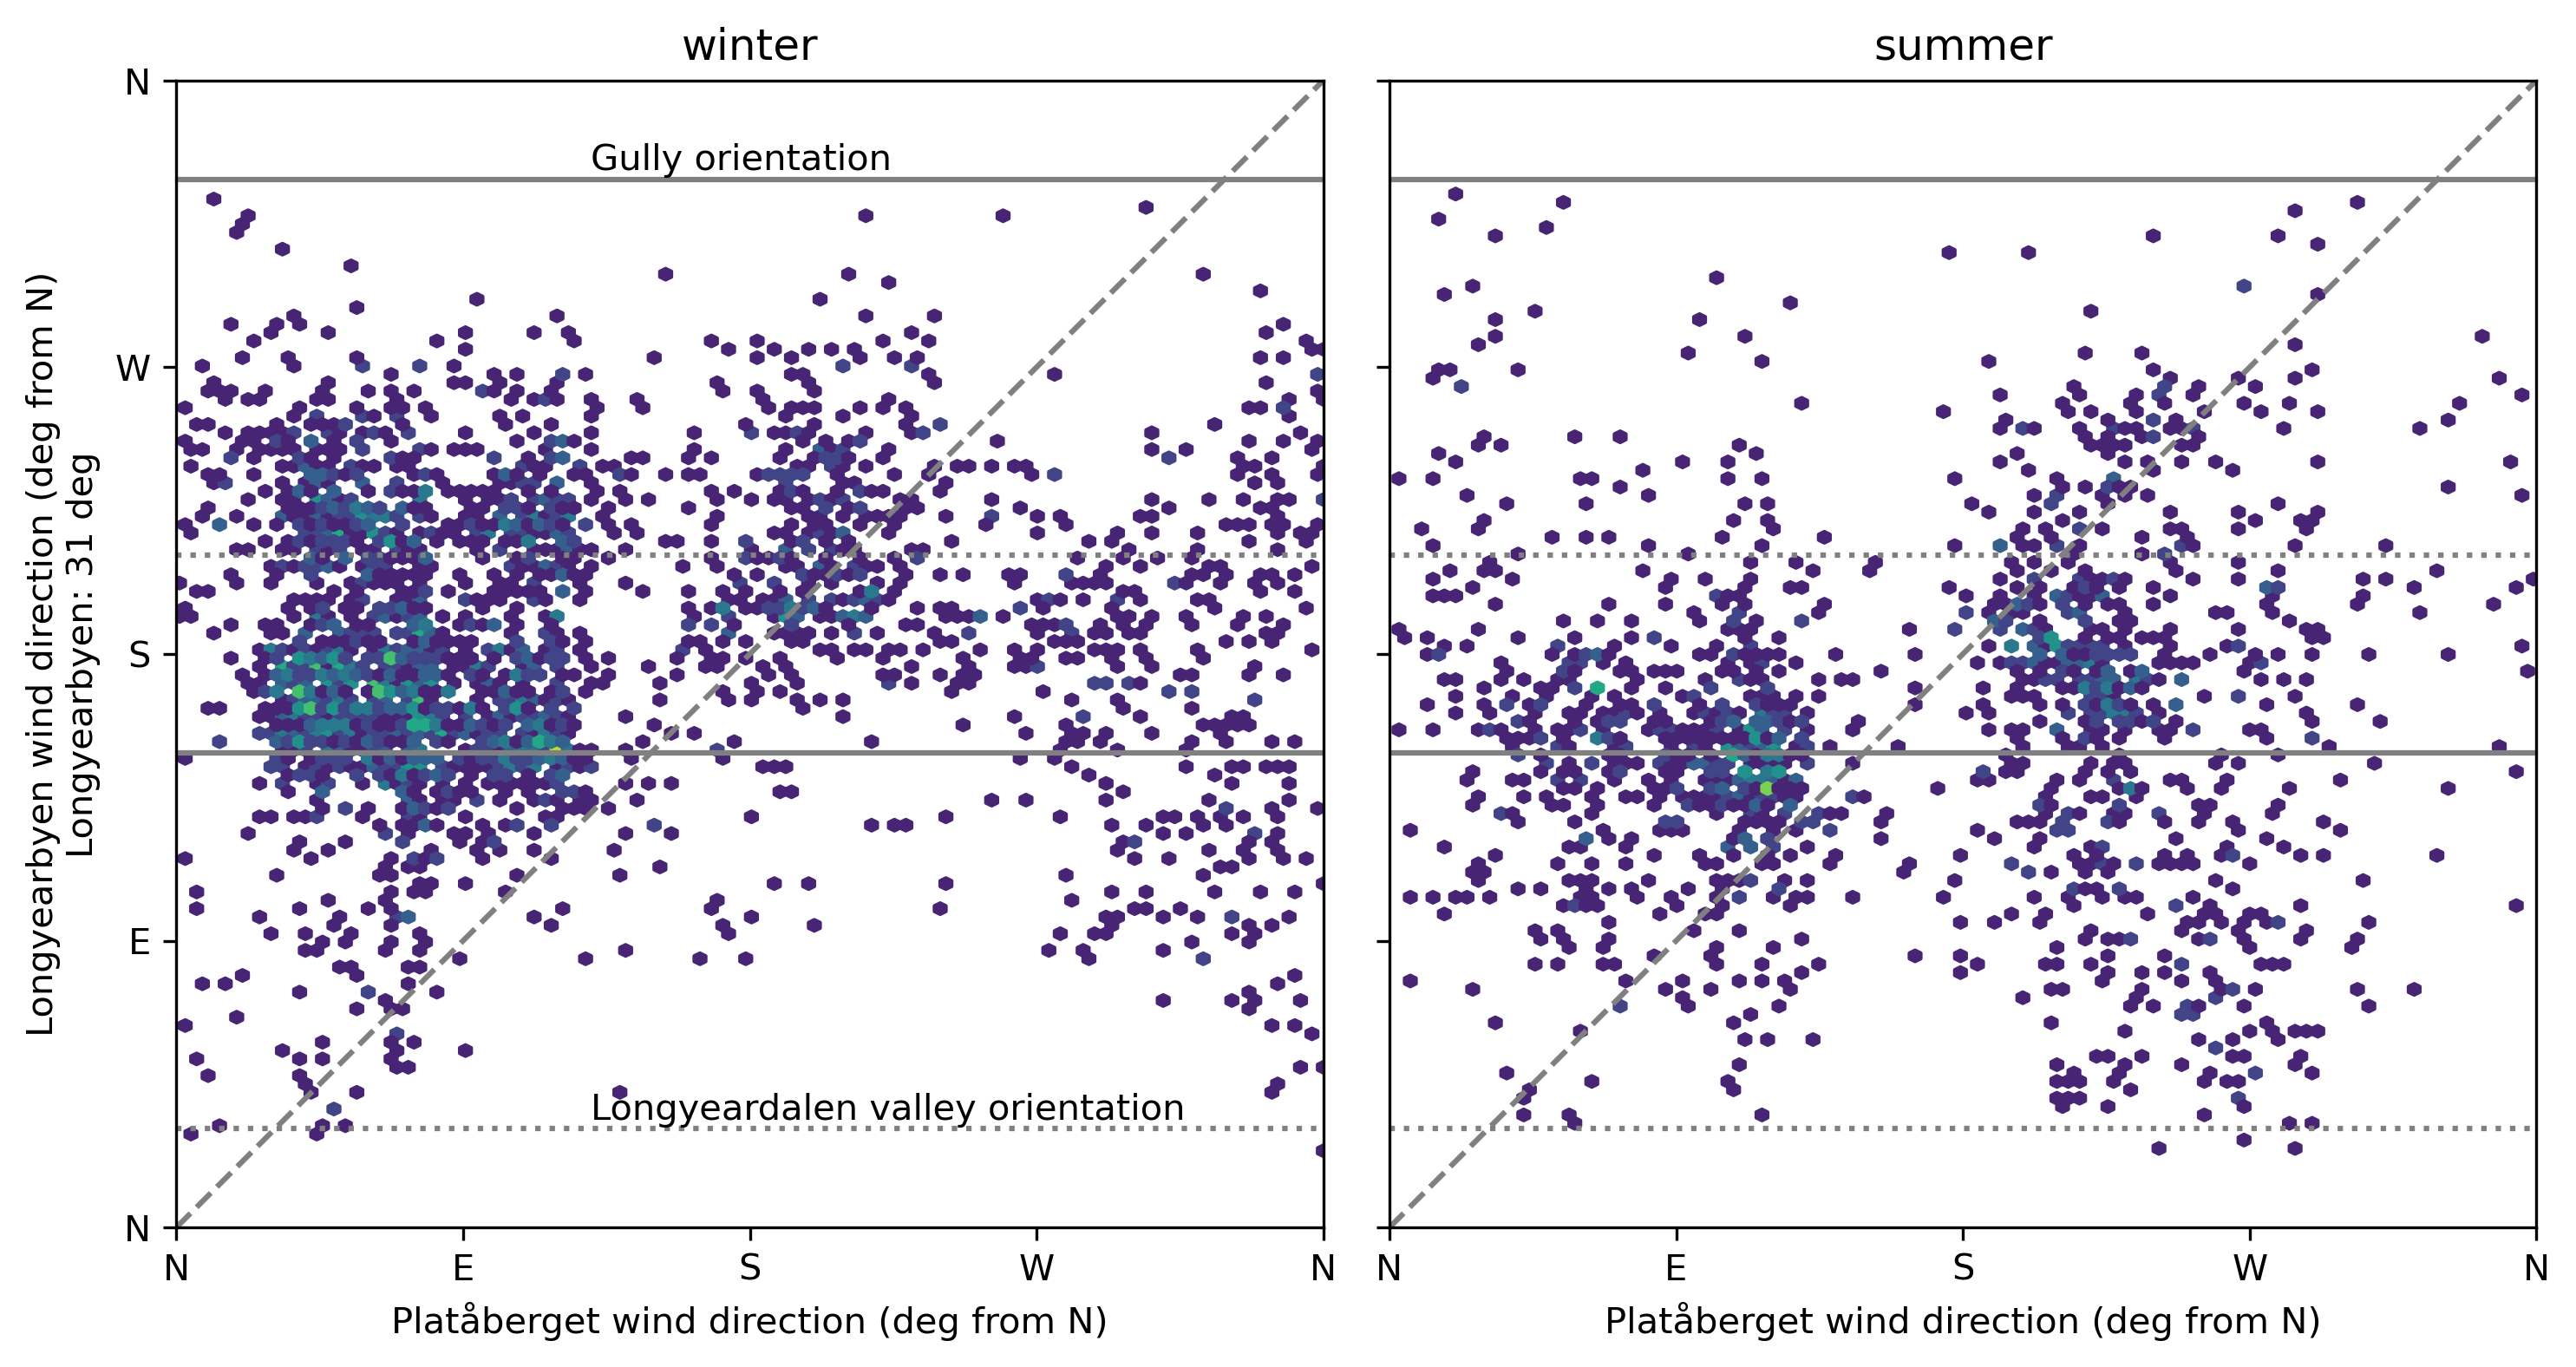

In [10]:
###### For wind speeds > than some value in m/s

fig,axs = plt.subplots(ncols=2, figsize=(10,6), sharex=True, sharey=True, dpi=300)
axs = axs.ravel()

vmax=10 # for scaling purposes
vmin=0

ws_min = 2

condi_ws = longyearbyen_plataberget_df.ws_plataberget>2

condi_m = longyearbyen_plataberget_df.index.month.isin([1,2,12])
axs[0].hexbin(longyearbyen_plataberget_df.loc[np.logical_and(condi_m, condi_ws)].wd_plataberget,
              longyearbyen_plataberget_df.loc[np.logical_and(condi_m, condi_ws)].wd_longyearbyen, mincnt=1, vmax=vmax, vmin=vmin)

axs[0].set_title('winter')


condi_m = longyearbyen_plataberget_df.index.month.isin([6,7,8])
axs[1].hexbin(longyearbyen_plataberget_df.loc[np.logical_and(condi_m, condi_ws)].wd_plataberget,
              longyearbyen_plataberget_df.loc[np.logical_and(condi_m, condi_ws)].wd_longyearbyen, mincnt=1, vmax=vmax, vmin=vmin)

axs[1].set_title('summer')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(0,360)
    ax.set_ylim(0,360)
    ax.axline([0,0], slope=1, c='grey', ls='--')
    ax.set_xticks([0,90,180,270,360], labels=['N','E','S','W','N'])
    ax.set_yticks([0,90,180,270,360], labels=['N','E','S','W','N'])
    ax.axhline(stations['SN99858']['valley_orientation'], ls=':', c='grey')
    ax.axhline(149, ls='-', c='grey')
    ax.axhline(149+180, ls='-', c='grey')
    ax.axhline(stations['SN99858']['valley_orientation']+180, ls=':', c='grey')
    #ax.grid()

for i in [0,1]: axs[i].set_xlabel('Platåberget wind direction (deg from N)')
    
axs[0].set_ylabel('Longyearbyen wind direction (deg from N)\nLongyearbyen: %i deg'
                 %(stations['SN99858']['valley_orientation']))
axs[0].text(130, stations['SN99858']['valley_orientation']+3, 'Longyeardalen valley orientation')

axs[0].text(130, 180+149+3, 'Gully orientation')
#fig.colorbar(pcm, ax=axs, orientation='horizontal', location='top', pad=-.45, shrink=.5, label='counts')

fig.tight_layout()

plt.savefig('../figs/seasonal_channeling_longyeardalen_VS_synoptic.png', bbox_inches='tight')


> **meh...**

# Adventdalen - Longyeardalen (with color from Platåberget wind speed)

In [18]:
ws_adventdalen = stations['SN99870']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_adventdalen'})
ws_longyearbyen = stations['SN99864']['wind_speed_data'].set_index('referenceTime').rename(columns={'value':'ws_longyearbyen'})
wd_adventdalen = stations['SN99870']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_adventdalen'})
wd_longyearbyen = stations['SN99864']['wind_direction_data'].set_index('referenceTime').rename(columns={'value':'wd_longyearbyen'})

print(ws_adventdalen.timeResolution.value_counts(), ws_longyearbyen.timeResolution.value_counts())
ws_longyearbyen = ws_longyearbyen.resample('h').mean(numeric_only=True).dropna(subset=['ws_longyearbyen'])
wd_longyearbyen = wd_longyearbyen.resample('h').mean(numeric_only=True).dropna(subset=['wd_longyearbyen'])

longyearbyen_adventdalen_df = pd.DataFrame(ws_longyearbyen.copy()['ws_longyearbyen'])

longyearbyen_adventdalen_df = longyearbyen_adventdalen_df.merge(wd_longyearbyen.wd_longyearbyen, left_index=True, right_index=True, how="left")
longyearbyen_adventdalen_df = longyearbyen_adventdalen_df.merge(ws_adventdalen.ws_adventdalen, left_index=True, right_index=True, how="left")
longyearbyen_adventdalen_df = longyearbyen_adventdalen_df.merge(wd_adventdalen.wd_adventdalen, left_index=True, right_index=True, how="left")
longyearbyen_adventdalen_df = longyearbyen_adventdalen_df.merge(ws_plataberget.ws_plataberget, left_index=True, right_index=True, how="left")
longyearbyen_adventdalen_df = longyearbyen_adventdalen_df.merge(wd_plataberget.wd_plataberget, left_index=True, right_index=True, how="left")

longyearbyen_adventdalen_df.dropna(axis=0, inplace=True)

timeResolution
PT1H    141234
Name: count, dtype: int64 timeResolution
PT1M    603045
Name: count, dtype: int64


In [19]:
import matplotlib.colors as mcolors

# Define a colorblind-friendly cyclical colormap
colors = [
    (0.0, 0.2, 0.9),  # Blue
    (0.6, 0.0, 0.6),  # Purple
    (0.8, 0.6, 0.0),  # Orange
    (0.6, 0.0, 0.6),  # Purple
    (0.0, 0.2, 0.9)   # Close loop back to Blue
]

# Create colormap
cm = mcolors.LinearSegmentedColormap.from_list("cyclical_cmap", colors, N=256)


/tmp/ipykernel_227956/4015325040.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


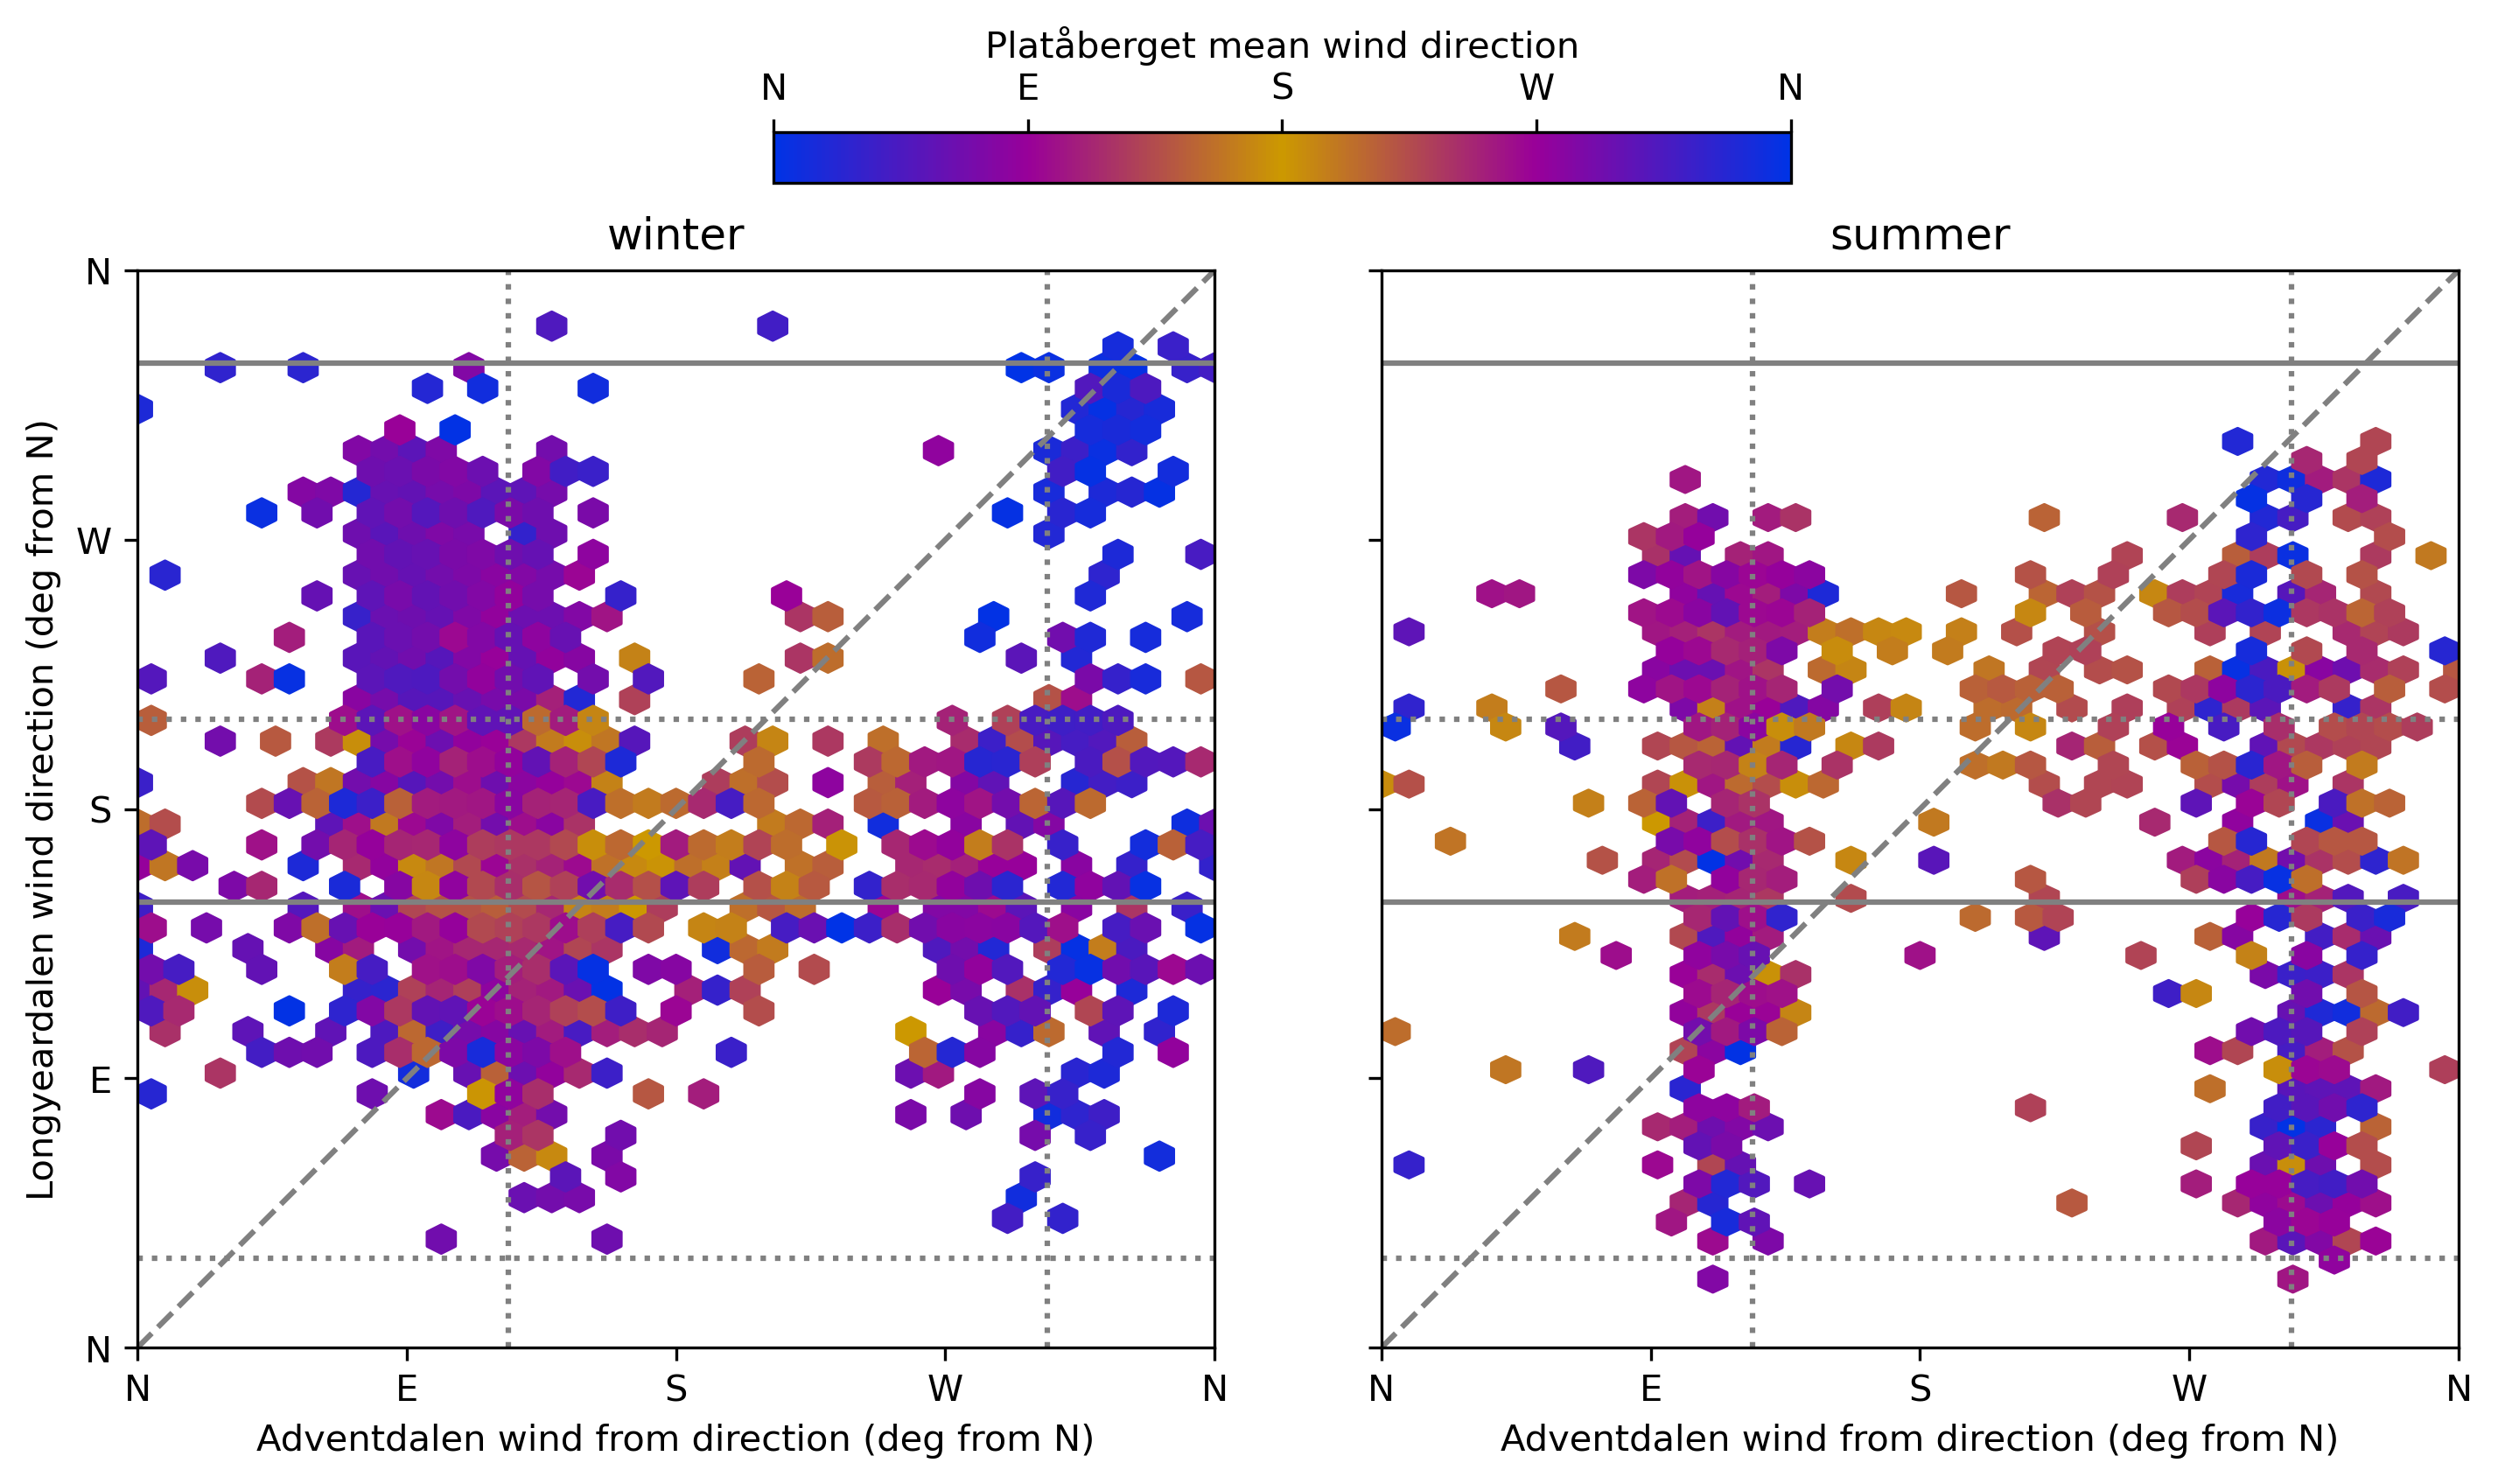

In [22]:
###### For wind speeds > than some value in m/s
fig,axs = plt.subplots(ncols=2, figsize=(10,6), sharex=True, sharey=True, dpi=300)
axs = axs.ravel()

vmax=360 # for scaling purposes
vmin=0

ws_min = 2

condi_ws = longyearbyen_adventdalen_df.ws_longyearbyen>0

condi_m = longyearbyen_adventdalen_df.index.month.isin([1,2,12])
pcm=axs[0].hexbin(longyearbyen_adventdalen_df.loc[np.logical_and(condi_m, condi_ws)].wd_adventdalen,
              longyearbyen_adventdalen_df.loc[np.logical_and(condi_m, condi_ws)].wd_longyearbyen,
              longyearbyen_adventdalen_df.loc[np.logical_and(condi_m, condi_ws)].wd_plataberget,
              reduce_C_function=mean_wind_direction, vmax=vmax, vmin=vmin, cmap=cm, gridsize=39)

axs[0].set_title('winter')


condi_m = longyearbyen_adventdalen_df.index.month.isin([6,7,8])
axs[1].hexbin(longyearbyen_adventdalen_df.loc[np.logical_and(condi_m, condi_ws)].wd_adventdalen,
              longyearbyen_adventdalen_df.loc[np.logical_and(condi_m, condi_ws)].wd_longyearbyen,
              longyearbyen_adventdalen_df.loc[np.logical_and(condi_m, condi_ws)].wd_plataberget,
              reduce_C_function=mean_wind_direction, vmax=vmax, vmin=vmin, cmap=cm, gridsize=39)

axs[1].set_title('summer')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(0,360)
    ax.set_ylim(0,360)
    ax.axline([0,0], slope=1, c='grey', ls='--')
    ax.set_xticks([0,90,180,270,360], labels=['N','E','S','W','N'])
    ax.set_yticks([0,90,180,270,360], labels=['N','E','S','W','N'])
    ax.axhline(stations['SN99864']['valley_orientation'], ls=':', c='grey')
    ax.axhline(stations['SN99864']['valley_orientation']+180, ls=':', c='grey')
    ax.axvline(stations['SN99870']['valley_orientation'], ls=':', c='grey')
    ax.axvline(stations['SN99870']['valley_orientation']+180, ls=':', c='grey')
    ax.axhline(149, ls='-', c='grey')
    ax.axhline(149+180, ls='-', c='grey')
    
    #ax.grid()

for i in [0,1]: axs[i].set_xlabel('Adventdalen wind from direction (deg from N)')
axs[0].set_ylabel('Longyeardalen wind direction (deg from N)')
cbar = fig.colorbar(pcm, ax=axs, orientation='horizontal', location='top', pad=-.45, shrink=.5, label='Platåberget mean wind direction',
            ticks=[0,90,180,270,360])
cbar.set_ticklabels(['N','E','S','W','N'])

fig.tight_layout()

plt.savefig('../figs/seasonal_channeling_adventdalen_VS_longyeardalen_with_plataberget.png', bbox_inches='tight')
